## HW9_zz1598


# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA subway ridership data
    

### DATA:
MTA subway fares-- a complete dataset of rides logged by card swipes for 600 Manhattan stations, 23 different card types(e.g. monthly pass, daily pass, Act for Disability pass, etc.)

[The data was organized by Sina Kashuk at CUSP]

In [109]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
#import os
import warnings
import datetime
from IPython.display import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.font_manager import FontProperties

import seaborn
import matplotlib.pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['power']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Note: 
Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. <br/>
Missing values are inputted as -1

In [111]:
# Get the data
mtarides = np.load('MTA_Fare.npy')

In [112]:
# Check the shape the data -- three dimensional
mtarides.shape

(600, 23, 194)

In [113]:
mtarides[0][:][:]

array([[56961, 64703, 68002, ..., 36527, 33929, 36824],
       [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
       [  203,   276,   245, ...,   186,   167,   167],
       ..., 
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [   -1,    -1,    -1, ...,  1121,  1377,   712]], dtype=int32)

#### Replace -1 with NaN in the np arrays

In [114]:
# Source: https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html
mtarides = np.where(mtarides !=-1, mtarides, NaN) 

In [115]:
mtarides[0][:][:]

array([[ 56961.,  64703.,  68002., ...,  36527.,  33929.,  36824.],
       [  1732.,   2083.,   2107., ...,   1264.,   1172.,   1238.],
       [   203.,    276.,    245., ...,    186.,    167.,    167.],
       ..., 
       [     0.,      0.,      0., ...,      0.,      0.,      0.],
       [     0.,      0.,      0., ...,      0.,      0.,      0.],
       [    nan,     nan,     nan, ...,   1121.,   1377.,    712.]])

#### Get the sum, mean of total number of riders by Station, Card Type and Week

In [116]:
# calculate the sum of rides per Station for 194 weeks
sum_byStation = np.nansum(mtarides, axis=1)
sum_byStation.shape

(600, 194)

In [117]:
mean_byStation = np.nanmean(mtarides, axis=1)
mean_byStation.shape

(600, 194)

In [118]:
sum_byStation

array([[ 126878.,  149477.,  152383., ...,   78901.,   74591.,   76833.],
       [  37306.,   46464.,   49359., ...,       0.,       0.,       0.],
       [   6606.,    6881.,    7229., ...,    8171.,    7907.,    6790.],
       ..., 
       [      0.,       0.,       0., ...,       0.,       0.,       0.],
       [      0.,       0.,       0., ...,       0.,       0.,       0.],
       [      0.,       0.,       0., ...,       0.,       0.,       0.]])

In [119]:
# calculate the sum of rides per Card Type for 194 weeks
sum_byCard = np.nansum(mtarides, axis=0)
sum_byCard.shape

(23, 194)

In [120]:
# calculate the sum and mean of rides per week
sum_byWeek = np.nansum(sum_byStation, axis=0)
mean_byWeek = np.nanmean(sum_byStation, axis=0)
print ('Shape--Sum pf rides each week: {}\nShape--Average rides each week: {}'.format(sum_byWeek.shape, mean_byWeek.shape))

Shape--Sum pf rides each week: (194,)
Shape--Average rides each week: (194,)


In [121]:
sum_byWeek[:9]

array([ 26720267.,  29265971.,  29601189.,  29387592.,  29185768.,
        26211666.,  28683614.,  29125646.,  28803814.])

In [122]:
mean_byWeek[:9]

array([ 44533.77833333,  48776.61833333,  49335.315     ,  48979.32      ,
        48642.94666667,  43686.11      ,  47806.02333333,  48542.74333333,
        48006.35666667])

In [123]:
# I pick the week range starting from Sunday 
start_date = datetime.date(2010,5,24).weekday()
end_date = datetime.date(2014,2,3).weekday() #end date is the first day of the last week of my range

print (start_date, end_date)

(0, 0)


In [124]:
# Show the end dates of each week within the date range I pick
#pd.Index(pd.date_range(pd.to_datetime('05/24/2010'), pd.to_datetime('02/09/2014'), freq='w'))
dates_all = pd.date_range('05/24/2010', periods=194, freq='W-SUN')
dates_all

DatetimeIndex(['2010-05-30', '2010-06-06', '2010-06-13', '2010-06-20',
               '2010-06-27', '2010-07-04', '2010-07-11', '2010-07-18',
               '2010-07-25', '2010-08-01',
               ...
               '2013-12-08', '2013-12-15', '2013-12-22', '2013-12-29',
               '2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26',
               '2014-02-02', '2014-02-09'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [125]:
dates_all.shape

(194,)

## Task 1: 
### Event detection: Identify the most prominent event by locating a significant drop (>3-sigma) in all time series.

In [21]:
# calculate mean and std for plotting
rides_weekly_mean = np.average(sum_byWeek/1e6) 
rides_weekly_std = np.nanstd(sum_byWeek/1e6)

In [22]:
rides_weekly_mean

29.781349871134019

In [25]:
rides_weekly_std

2.9839604217008859

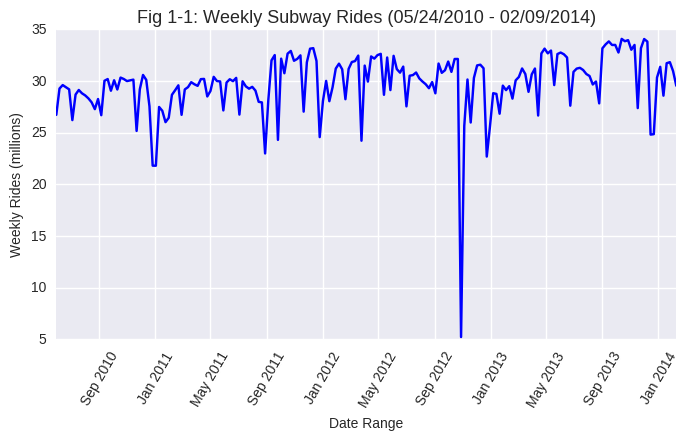

In [24]:
# plot the total rides per week timeseries
pl.figure(figsize=(8,4))
pl.plot(dates_all, sum_byWeek/1e6, 'blue')
pl.ylabel('Weekly Rides (millions)', size=10)
pl.xlabel('Date Range', size=10)
pl.xticks(rotation=60)
pl.title('Fig 1-1: Weekly Subway Rides (05/24/2010 - 02/09/2014)', size = 13)

**Figure 1-1**: The plot shows the weekly total number of subway rides from 2010/5/24 to 2014/2/9. A significant drop ( > 3$\sigma$ ) in a week between 2012/9 and 2013/1 can be obersved. I will find out what exact date that is to be able to find out the cause of the decrease.

In [26]:
sum_byWeek.argmin()  # The lowest value in the index of sum_byWeek array (the 127th week)

126

In [27]:
# Pick the zoom-in date range
dates_all[124:128]

DatetimeIndex(['2012-10-14', '2012-10-21', '2012-10-28', '2012-11-04'], dtype='datetime64[ns]', freq='W-SUN')

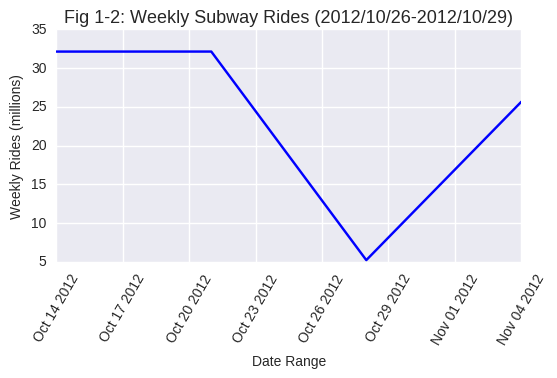

In [29]:
# Zoom in
# Visualize the specific date of the drop within a small dates range
pl.figure(figsize=(6,3))
pl.plot(dates_all[124:128], sum_byWeek[124:128]/1e6, 'blue')
pl.ylabel('Weekly Rides (millions)', size=10)
pl.xlabel('Date Range', size=10)
pl.xticks(rotation=60)
pl.title('Fig 1-2: Weekly Subway Rides (2012/10/14-2012/11/4)', size = 13)

**Figure 1-2**: The plot shows a zoomed-in view of weekly total number of subway rides from the 2012 October 14 to Novemver 4. From this we can locate the significant drop occuring from 2012/10/26 to 2012/10/29, approximately around 10/28. 
By researching, there are records showing that during those days, **Hurricane Sandy** hit NYC, which caused suspension of the subway system operation.  

## Task 2: 
### Knowing that some of the time series are stationary, some have a complex structure, and some show a downward trend, I will identify the **ridership types**  with steadily increase/decrease in popularity.  
(I will calculate the ratio of usage in the first 10 and last 10 weeks of the date range)

In [31]:
# View the two dimensional card type data in a data frame
df_ridetype = pd.DataFrame(sum_byCard)
df_ridetype.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,11494615.0,12526859.0,12766627.0,12653675.0,12809694.0,11429783.0,12346877.0,12576759.0,12437115.0,12431257.0,...,14604028.0,11344945.0,11223430.0,12864865.0,12904811.0,11932970.0,13139360.0,13189610.0,12500756.0,12459947.0
1,530524.0,583533.0,586194.0,562602.0,548858.0,455691.0,518187.0,513412.0,512192.0,522569.0,...,781529.0,596341.0,518956.0,664531.0,744990.0,613294.0,713717.0,695134.0,670228.0,679497.0
2,47801.0,51486.0,51636.0,52063.0,51153.0,46852.0,48963.0,49629.0,49030.0,50376.0,...,62658.0,50820.0,45153.0,56129.0,60429.0,51664.0,57208.0,58771.0,56525.0,55192.0
3,186551.0,199229.0,199668.0,196389.0,194883.0,175648.0,188467.0,188090.0,186822.0,190528.0,...,193268.0,164607.0,148652.0,177885.0,193547.0,168932.0,189564.0,184239.0,180029.0,179363.0
4,46808.0,64353.0,56994.0,37429.0,35210.0,46849.0,60225.0,47439.0,32084.0,52171.0,...,56671.0,22623.0,25301.0,67713.0,64867.0,43426.0,47804.0,61101.0,59400.0,46859.0


In [32]:
# Set the index to be name of the card types
df_ridetype.index = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [33]:
df_ridetype.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
10t,11494615.0,12526859.0,12766627.0,12653675.0,12809694.0,11429783.0,12346877.0,12576759.0,12437115.0,12431257.0,...,14604028.0,11344945.0,11223430.0,12864865.0,12904811.0,11932970.0,13139360.0,13189610.0,12500756.0,12459947.0
14d,530524.0,583533.0,586194.0,562602.0,548858.0,455691.0,518187.0,513412.0,512192.0,522569.0,...,781529.0,596341.0,518956.0,664531.0,744990.0,613294.0,713717.0,695134.0,670228.0,679497.0
1d,47801.0,51486.0,51636.0,52063.0,51153.0,46852.0,48963.0,49629.0,49030.0,50376.0,...,62658.0,50820.0,45153.0,56129.0,60429.0,51664.0,57208.0,58771.0,56525.0,55192.0
2t,186551.0,199229.0,199668.0,196389.0,194883.0,175648.0,188467.0,188090.0,186822.0,190528.0,...,193268.0,164607.0,148652.0,177885.0,193547.0,168932.0,189564.0,184239.0,180029.0,179363.0
30d,46808.0,64353.0,56994.0,37429.0,35210.0,46849.0,60225.0,47439.0,32084.0,52171.0,...,56671.0,22623.0,25301.0,67713.0,64867.0,43426.0,47804.0,61101.0,59400.0,46859.0


In [34]:
df_ridetype.columns

RangeIndex(start=0, stop=194, step=1)

In [36]:
# Drop the 127th week when Sandy occured for trend analysis
df_ridetype2 = df_ridetype.drop([126], axis=1)
df_ridetype2.shape

(23, 193)

In [39]:
df_ridetype2.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
10t,11494615.0,12526859.0,12766627.0,12653675.0,12809694.0,11429783.0,12346877.0,12576759.0,12437115.0,12431257.0,...,14604028.0,11344945.0,11223430.0,12864865.0,12904811.0,11932970.0,13139360.0,13189610.0,12500756.0,12459947.0
14d,530524.0,583533.0,586194.0,562602.0,548858.0,455691.0,518187.0,513412.0,512192.0,522569.0,...,781529.0,596341.0,518956.0,664531.0,744990.0,613294.0,713717.0,695134.0,670228.0,679497.0
1d,47801.0,51486.0,51636.0,52063.0,51153.0,46852.0,48963.0,49629.0,49030.0,50376.0,...,62658.0,50820.0,45153.0,56129.0,60429.0,51664.0,57208.0,58771.0,56525.0,55192.0
2t,186551.0,199229.0,199668.0,196389.0,194883.0,175648.0,188467.0,188090.0,186822.0,190528.0,...,193268.0,164607.0,148652.0,177885.0,193547.0,168932.0,189564.0,184239.0,180029.0,179363.0
30d,46808.0,64353.0,56994.0,37429.0,35210.0,46849.0,60225.0,47439.0,32084.0,52171.0,...,56671.0,22623.0,25301.0,67713.0,64867.0,43426.0,47804.0,61101.0,59400.0,46859.0


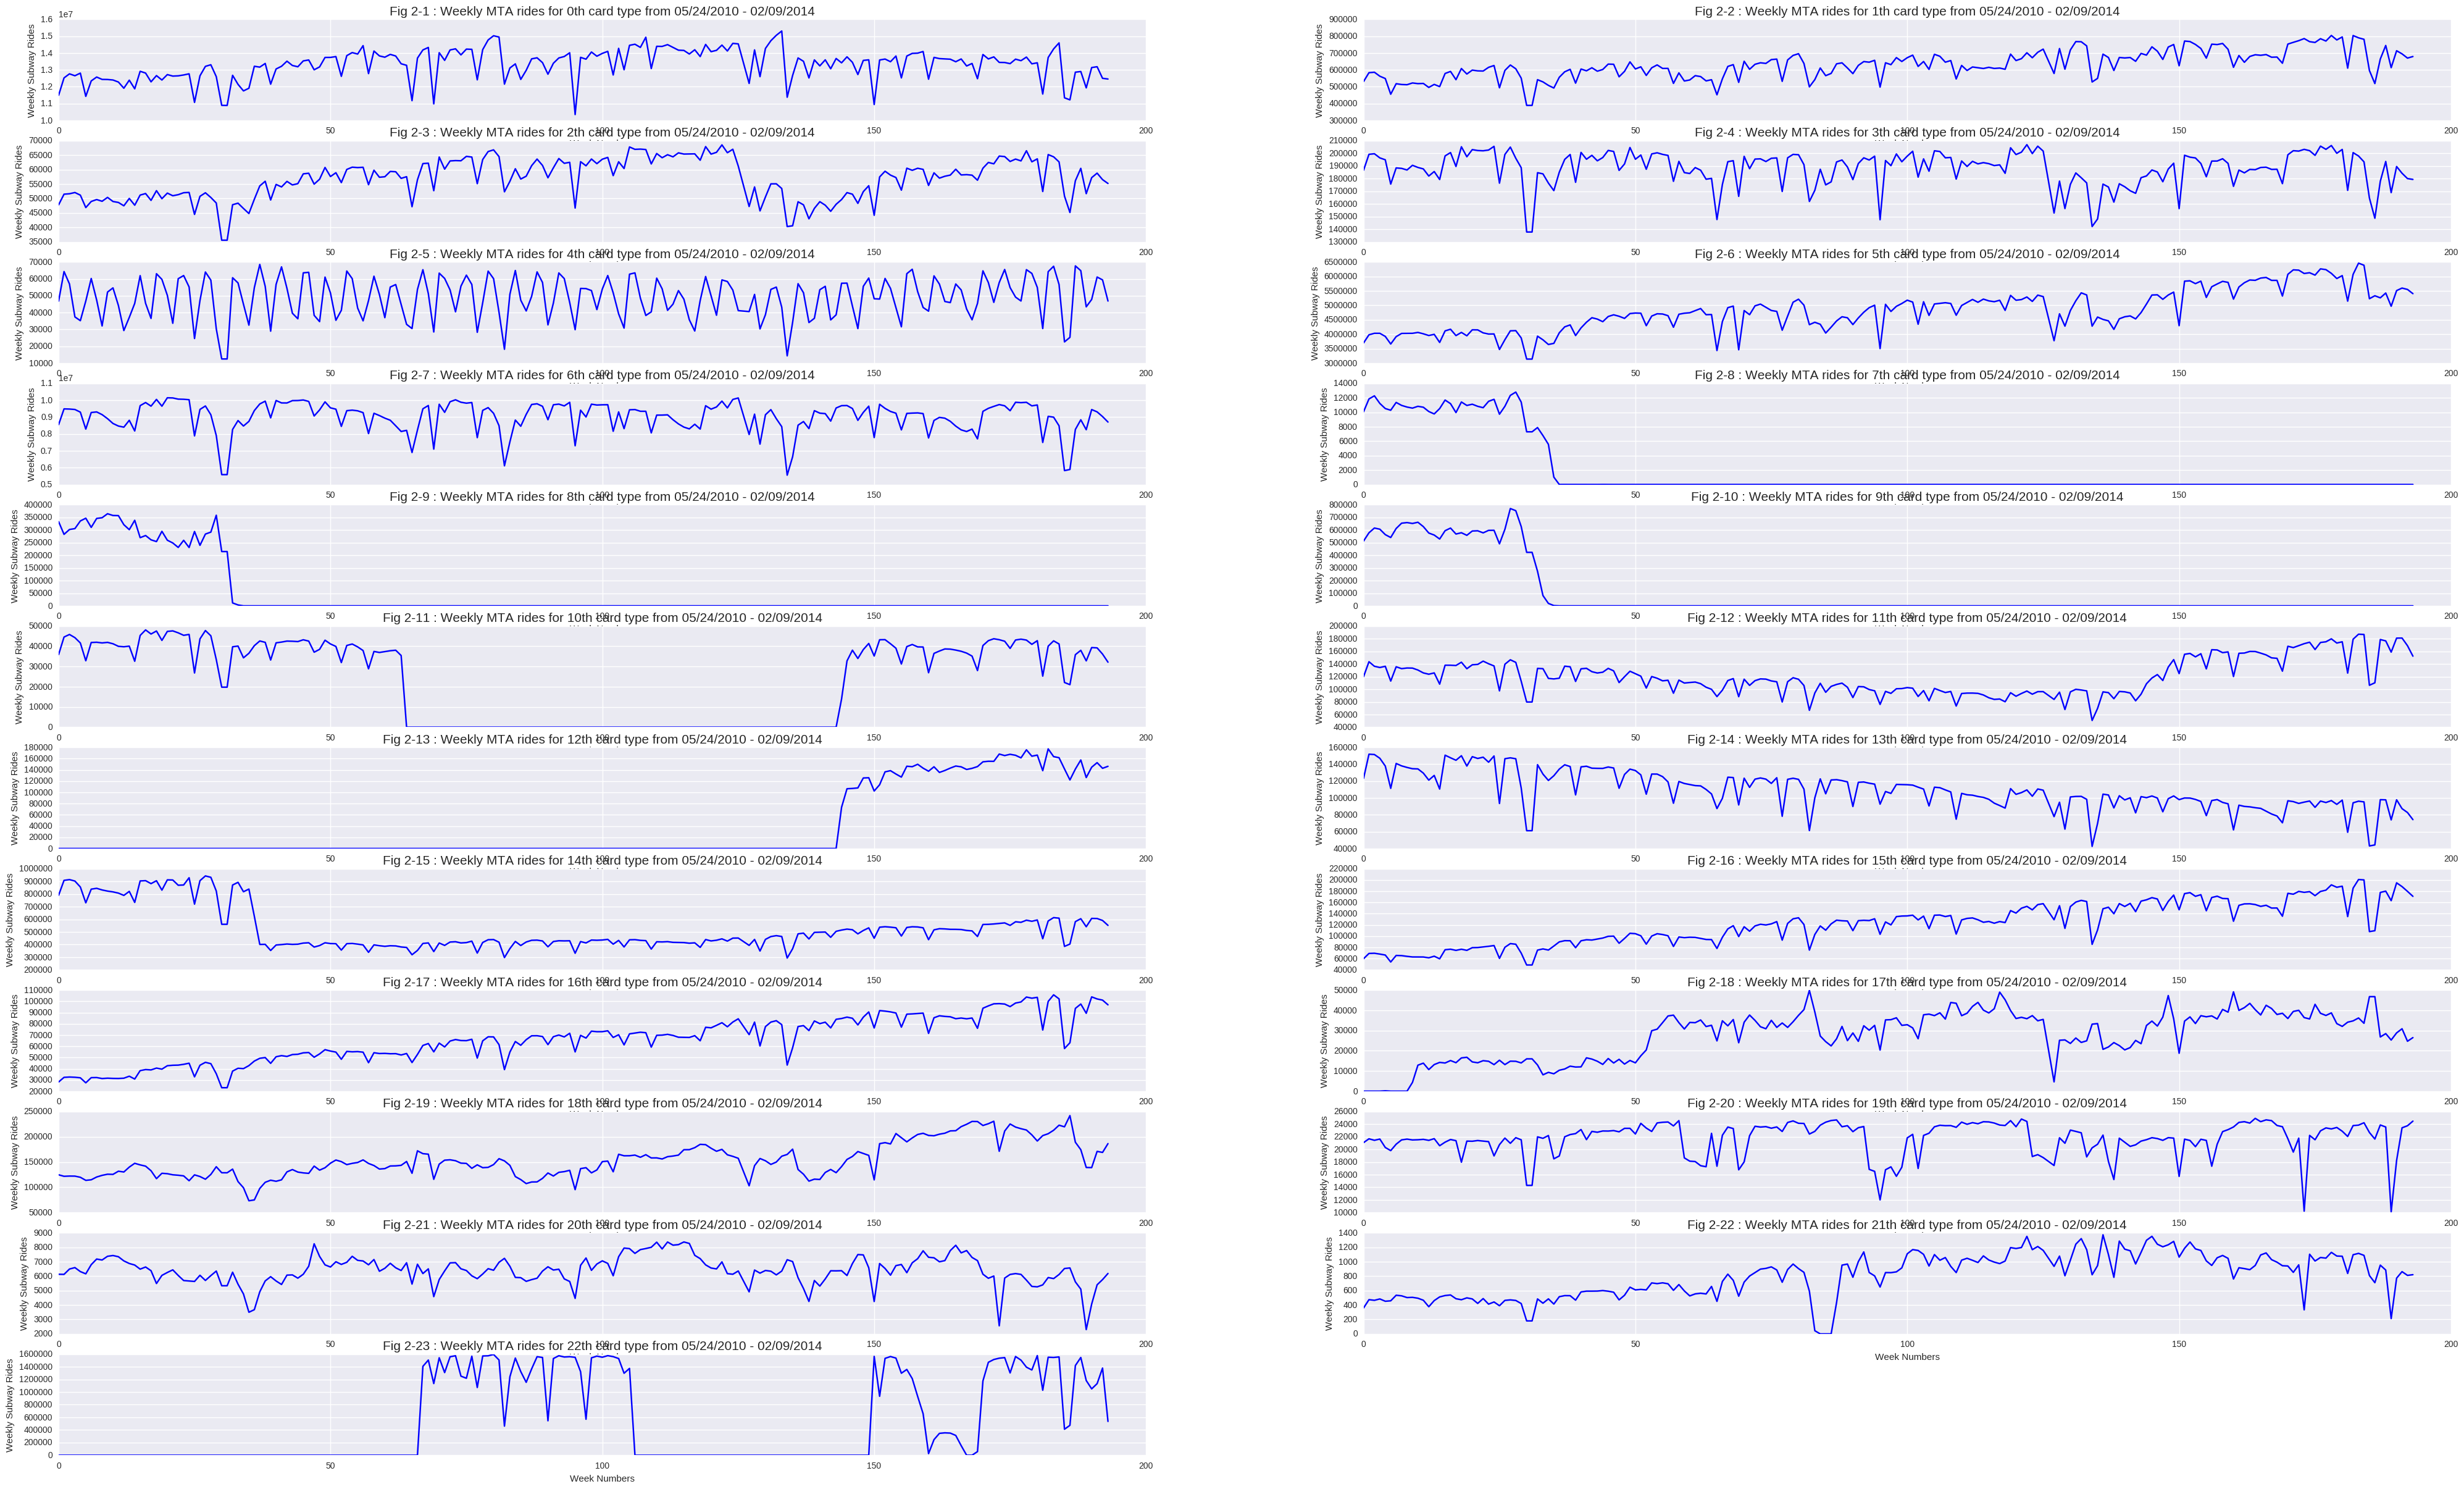

In [129]:
#plot to visualize the overall trends in each of the top stations
plt.figure(figsize=(50,30)) 
for i in xrange(23):
    pl.subplot(12,2,i+1)
    pl.plot(df_ridetype2.ix[i,:], 'blue')
    pl.ylabel('Weekly Subway Rides', size=11)
    pl.xlabel('Week Numbers', size=11)
    pl.xticks()
    pl.title(('Fig 2-%s : Weekly MTA rides for %sth card type from 05/24/2010 - 02/09/2014'%(i+1, i)), size = 15)

**Figure 2-1~2-23**: The plots demonstrate the trends of ridership for each card type in the 193 weeks (excluding the "Sandy" week. Some have obvious steady curves while some fluctuate a lot. From the graphs, I pick the ones that are not includig missing values and also seemingly steady. <br/>
**Those are card types corresponding to index 0, 1, 2, 3, 4, 5, 6, 13, 15, 16, 18, 20**

In [43]:
# Keep only the card types with relatively steady trends in usage
df_ridetype3 = df_ridetype2.ix[(0, 1, 2, 3, 4, 5, 6, 13, 15, 16, 18, 20),:]
df_ridetype3.shape

(12, 193)

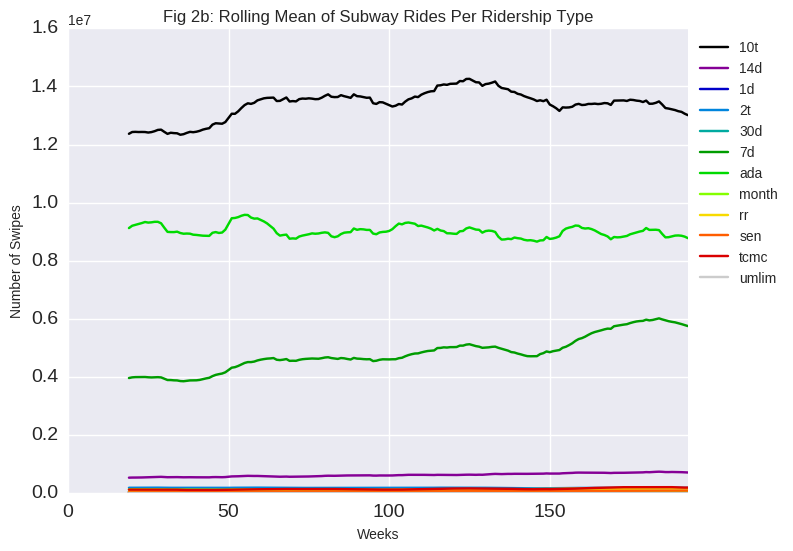

In [46]:
# use rolling mean to smooth the curves
df_ridetype_rollmean = df_ridetype3.T.rolling(window = 20, center = False).mean().plot(figsize=(8,6), \
                        title='Fig 2b: Rolling Mean of Subway Rides Per Ridership Type', \
                        fontsize=14, cmap='spectral')
plt.ylabel('Number of Swipes', size = 10)
plt.xlabel('Weeks', size = 10)
plt.legend(loc='best', fontsize = 10, bbox_to_anchor=(1,1)) 
# Consulted on:
# http://www.jacksimpson.co/2016/01/11/positioning-a-legend-outside-the-figure-with-matplotlib-and-python/

**Figure 2**: Shows the sum of subway ridership per week for every card type in NYC, smoothed with rolling mean method. Then we can calculate the ratios for the first and the last 10 weeks.

In [49]:
# Calculate the rolling means of the rides for the first and the last 10 weeks
weeks_first10 = df_ridetype3.T.rolling(window = 10, center = False).mean().dropna().head(10)
weeks_last10 = df_ridetype3.T.rolling(window = 10, center = False).mean().dropna().tail(10)

In [50]:
# Calculate the ratio
weeks_first10.index = np.arange(10)
weeks_last10.index = np.arange(10)
ratio = (weeks_last10 - weeks_first10)/ weeks_first10 
#ratio.head()
ratio.mean()

10t      0.049924
14d      0.351412
1d       0.180673
2t      -0.017215
30d      0.119884
7d       0.442451
ada     -0.063401
month   -0.382642
rr       1.631852
sen      1.850749
tcmc     0.589222
umlim   -0.188815
dtype: float64

### Comparing the last 10 weeks' riderships and the first 10 weeks' riderships of each card type,
### -- the card types with relatively obvious steady increasing trends : 14d, 7d, rr, sen, tcmc
### -- the card type with relatively steady decreasing usage trends : month

#### There are card types with very slight changes: 10t, 1d, 30d(very slight increase); 2t, ada, umlim(very slight decrease)

In [52]:
# Look into the card types that are likely to have steady increasing/decreasing trends
df_ridetype4 = df_ridetype3.ix[('14d', '7d', 'rr', 'sen', 'tcmc','month'),:]
df_ridetype4

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
14d,530524.0,583533.0,586194.0,562602.0,548858.0,455691.0,518187.0,513412.0,512192.0,522569.0,...,781529.0,596341.0,518956.0,664531.0,744990.0,613294.0,713717.0,695134.0,670228.0,679497.0
7d,3697443.0,3981808.0,4033030.0,4032753.0,3925446.0,3663144.0,3918104.0,4028251.0,4030717.0,4032340.0,...,6388538.0,5230565.0,5332925.0,5260402.0,5427174.0,4970067.0,5511613.0,5599237.0,5551292.0,5405077.0
rr,59809.0,69209.0,69574.0,68099.0,66377.0,54034.0,65635.0,65351.0,64066.0,63006.0,...,200134.0,108113.0,109729.0,177831.0,180140.0,163216.0,194920.0,188230.0,179707.0,170854.0
sen,28221.0,32333.0,32618.0,32404.0,31933.0,27469.0,32065.0,32159.0,31284.0,31600.0,...,102199.0,57964.0,63133.0,93693.0,97596.0,89354.0,103961.0,102124.0,101071.0,96887.0
tcmc,124693.0,121713.0,122181.0,122051.0,119776.0,113699.0,114803.0,120293.0,123578.0,125819.0,...,222764.0,219592.0,241777.0,189121.0,174323.0,139163.0,138907.0,170980.0,168923.0,186362.0
month,123134.0,151948.0,151538.0,147094.0,137888.0,111425.0,140932.0,138075.0,136229.0,134701.0,...,95330.0,43042.0,44280.0,97982.0,97797.0,73993.0,97828.0,87308.0,82733.0,74272.0


In [53]:
# Calculate the 1st discrete difference of the riderships between weeks to remove trends
df_diff = df_ridetype4.diff(periods=1, axis=1)

In [55]:
df_diff 

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
14d,NaN,53009.0,2661.0,-23592.0,-13744.0,-93167.0,62496.0,-4775.0,-1220.0,10377.0,...,-8890.0,-185188.0,-77385.0,145575.0,80459.0,-131696.0,100423.0,-18583.0,-24906.0,9269.0
7d,NaN,284365.0,51222.0,-277.0,-107307.0,-262302.0,254960.0,110147.0,2466.0,1623.0,...,-73197.0,-1157973.0,102360.0,-72523.0,166772.0,-457107.0,541546.0,87624.0,-47945.0,-146215.0
rr,NaN,9400.0,365.0,-1475.0,-1722.0,-12343.0,11601.0,-284.0,-1285.0,-1060.0,...,-702.0,-92021.0,1616.0,68102.0,2309.0,-16924.0,31704.0,-6690.0,-8523.0,-8853.0
sen,NaN,4112.0,285.0,-214.0,-471.0,-4464.0,4596.0,94.0,-875.0,316.0,...,-3604.0,-44235.0,5169.0,30560.0,3903.0,-8242.0,14607.0,-1837.0,-1053.0,-4184.0
tcmc,NaN,-2980.0,468.0,-130.0,-2275.0,-6077.0,1104.0,5490.0,3285.0,2241.0,...,9996.0,-3172.0,22185.0,-52656.0,-14798.0,-35160.0,-256.0,32073.0,-2057.0,17439.0
month,NaN,28814.0,-410.0,-4444.0,-9206.0,-26463.0,29507.0,-2857.0,-1846.0,-1528.0,...,-850.0,-52288.0,1238.0,53702.0,-185.0,-23804.0,23835.0,-10520.0,-4575.0,-8461.0


In [57]:
# Perform AD Fuller test to test the stationarity for each card types after removing the trends
print ("diffstationary, AD Fuller test\n")

for i in xrange(df_diff.shape[0]):
    print ("Rides of card type {} : {:.2f}".format(df_diff.index[i], sm.tsa.adfuller(df_diff.ix[i,1:])[1]))

diffstationary, AD Fuller test

Rides of card type 14d : 0.00
Rides of card type 7d : 0.00
Rides of card type rr : 0.00
Rides of card type sen : 0.00
Rides of card type tcmc : 0.00
Rides of card type month : 0.00


### Result Interpretation:
The test verifies that the card types picked above are **stationary** (p-value = 0 indicates that there is no unit root), which means that the riderships of these card types are **increasing or decreading steadily**.

## Task 3:
### I will identify the four stations that show the most prominent periodic trends on an annual period (52 weeks)
#### Technique: Fourier Transformation

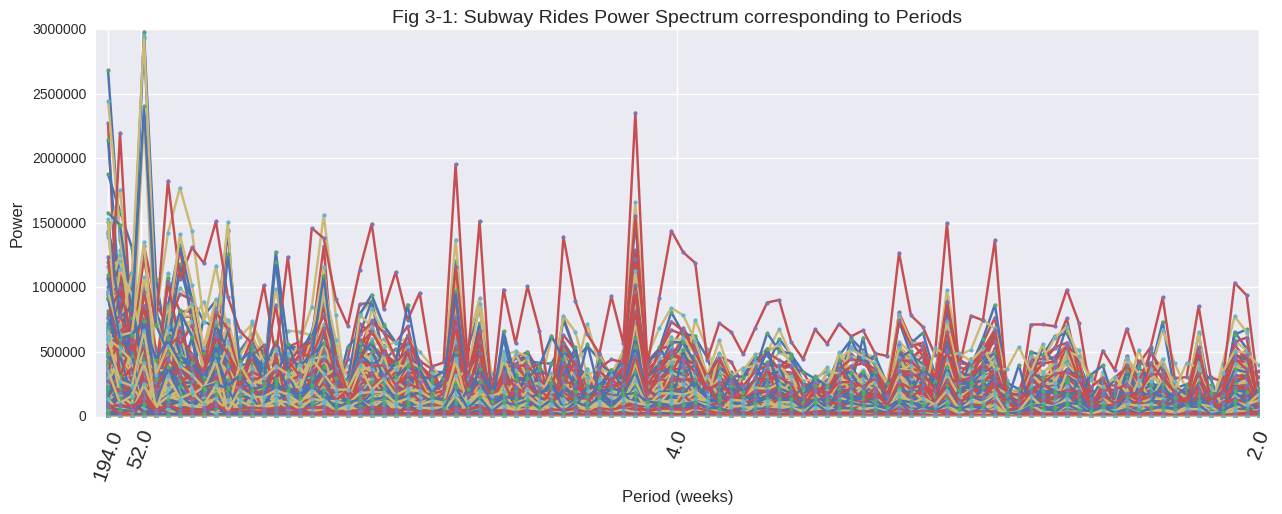

In [64]:
# Plot the power of the frequencies against frequencies. (I label the x-axis as periods for easier interpretaion)
N = len(sum_byStation[0])  # N = 194 (weeks)
x_labels = [1.0/194.0, 1.0/52.0, 1.0/4.0, 1.0/2.0]  #frequencies

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in xrange(len(sum_byStation)):
    fpower = np.abs(np.fft.rfft(sum_byStation[i])) # power
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (fpower[1:]), '-')   # x-axis: frequency, y-axis: power
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (fpower[1:]), 'o', ms=3)


ax.set_xticks(x_labels)
ax.set_xticklabels([194.0, 52.0, 4.0, 2.0], fontsize=15, rotation = 70) #label the x-axis as periods, which is 1/frequency

plt.xlabel("Period (weeks)", fontsize=12)
plt.ylabel("Power", fontsize=12)
plt.title("Fig 3-1: Subway Rides Power Spectrum corresponding to Periods", fontsize=14)

**Figure 3-1**: From the Power Spectrum plot we can see that the largest power occurs around the period of 52 weeks. So I have located my targeted periodicity. This means that the stations with the highest power at this frequency are what I am looking for.

In [69]:
# store all the power into a list
power_all = np.abs(np.fft.rfft(sum_byStation))
power_all.shape

(600, 98)

In [71]:
# locate the index that corresponds to the maximum power
power_ind = power_all[327][1:].argmax()
power_ind

3

In [79]:
# use the index above to find the corresponding maximum power and store those into a list
# the maximum power occurs around 52 weeks, so the most prominent periodicity is on an annual basis
power_max_52w = []  
for i in xrange(len(power_all[:][1:])):   #remove the first column to avoid noise
    power = power_all[i][power_ind + 1]  
    power_max_52w.append(power)

In [80]:
power_max_52w[:5]

[2980160.6355953491,
 517792.73741749104,
 24753.350436413995,
 88385.081890831862,
 52457.80231399824]

In [81]:
len(power_max_52w)

599

In [83]:
df = pd.DataFrame(power_max_52w, columns=['Power of Periodicity'])
df.sort_values(by=['Power of Periodicity'],ascending = False, inplace = True)
df.head(4)

,Power of Periodicity
0,2.980161e+06
194,2.950389e+06
150,2.931896e+06
327,2.402219e+06


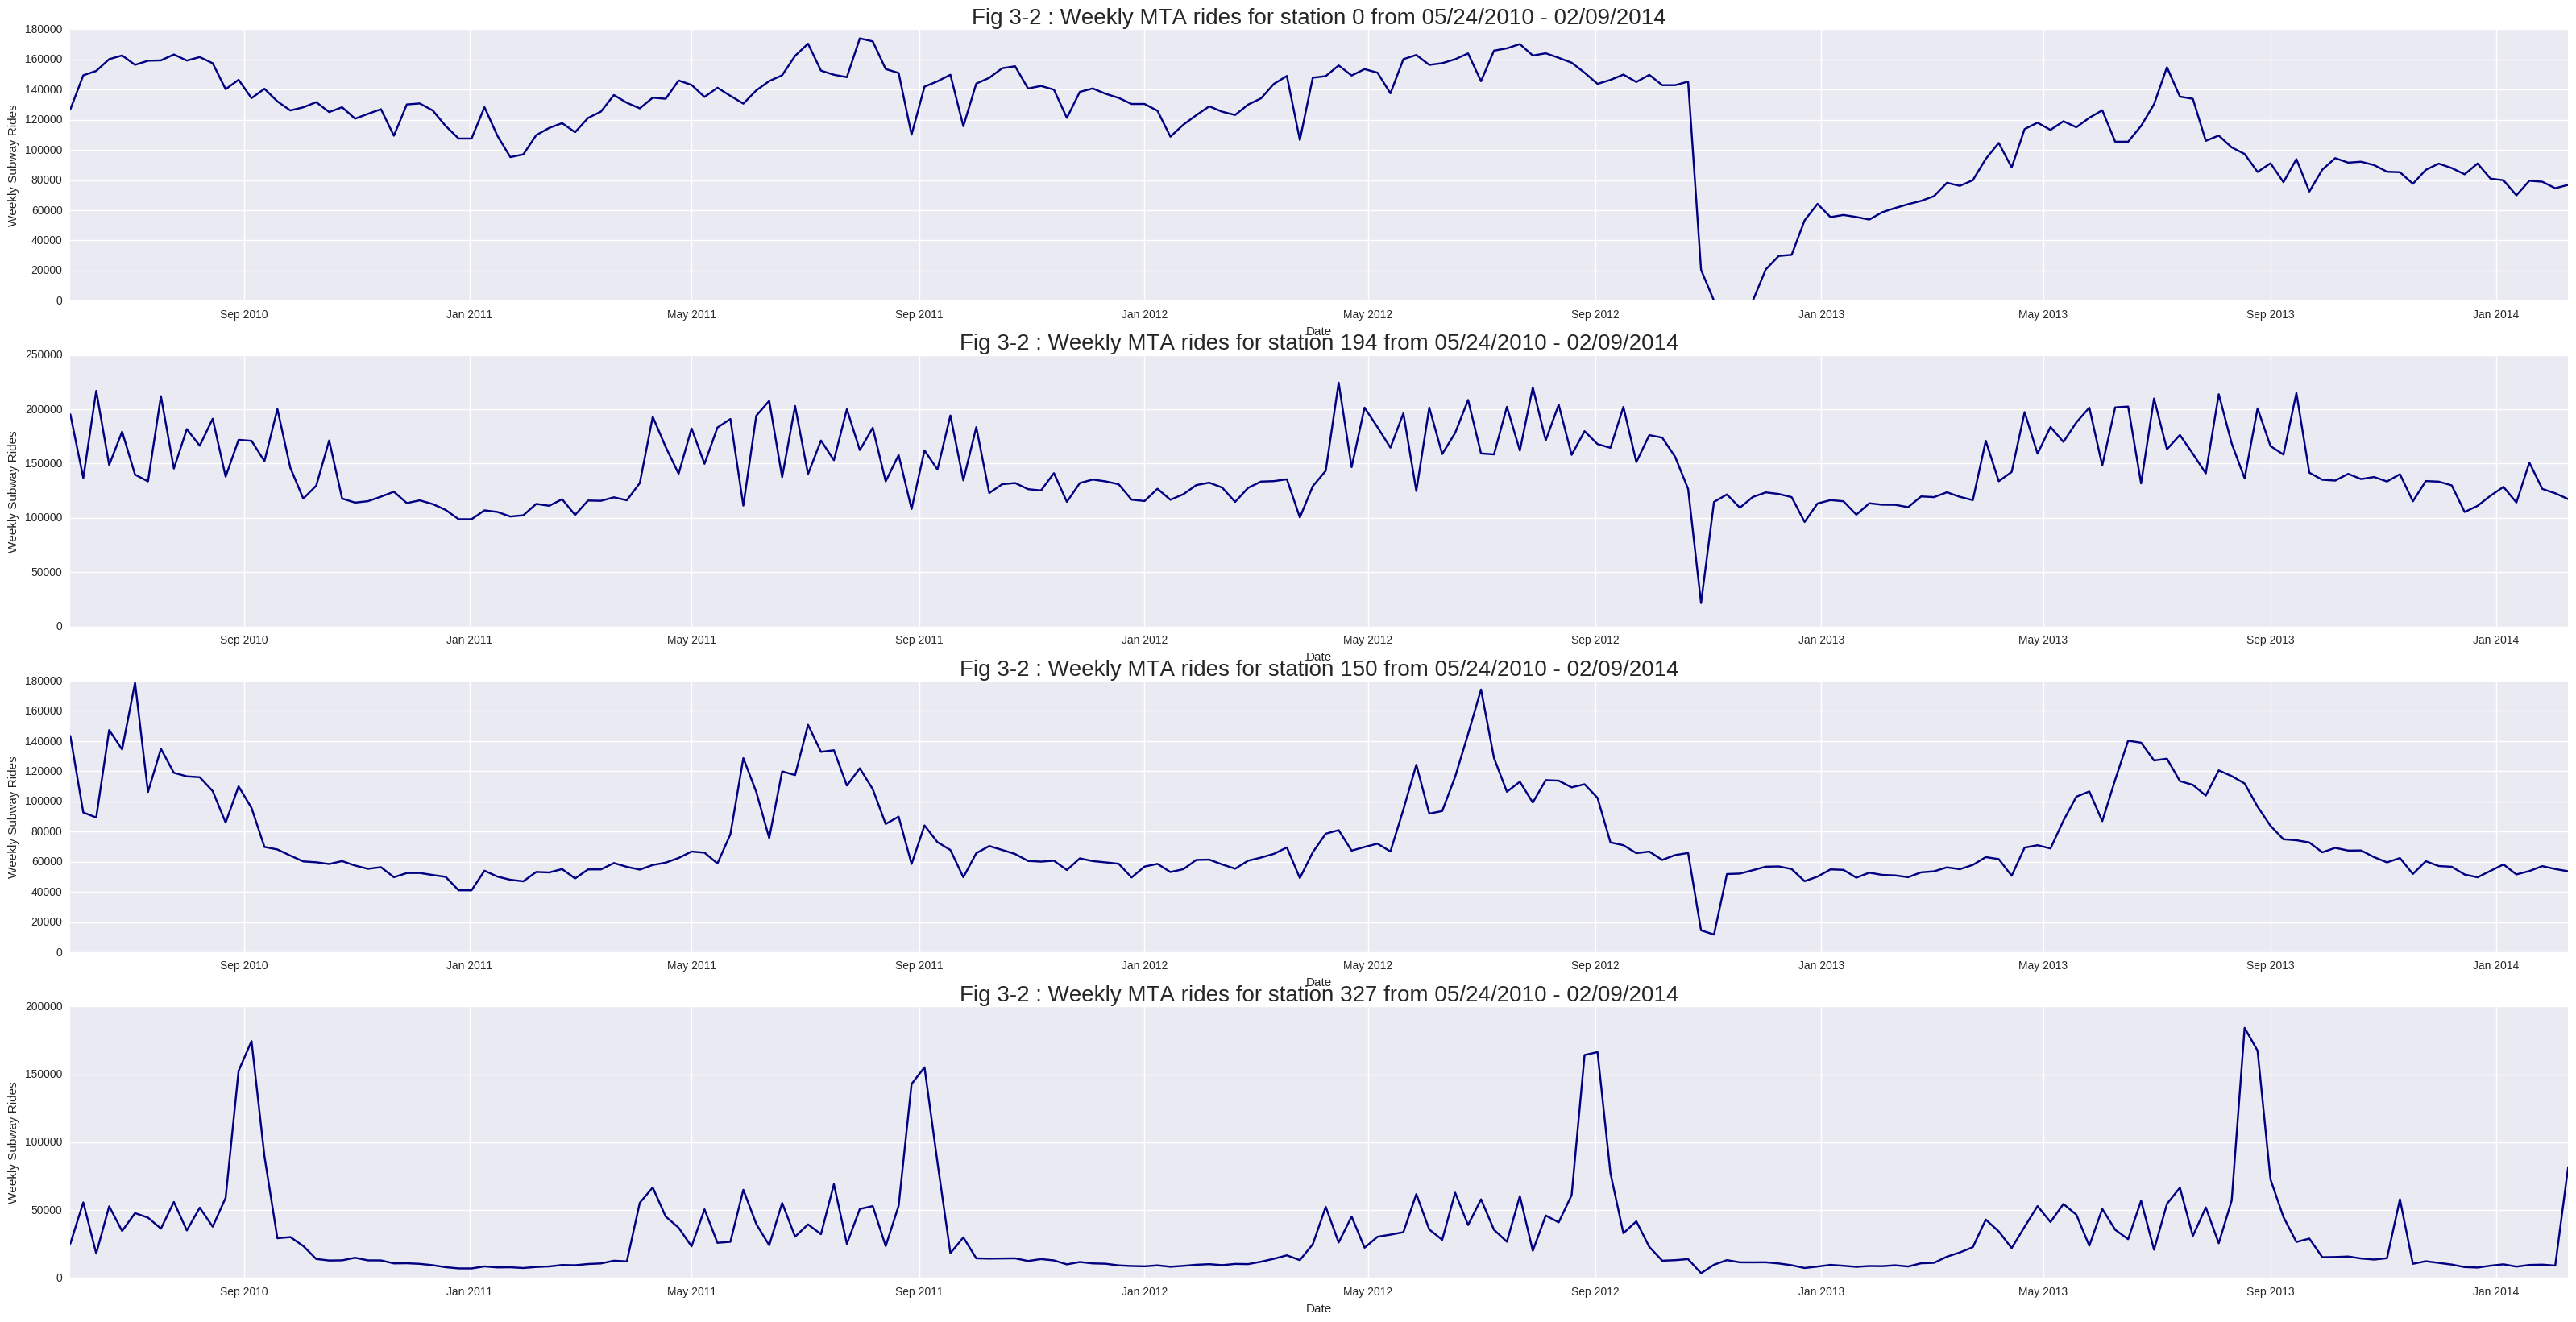

In [87]:
#plot to visualize the periodicity in each of the top stations
plt.figure(figsize = (40, 20)) 
for i,sta_id in enumerate([0, 194, 150, 327]):
    pl.subplot(4,1,i+1)
    pl.plot(dates_all, sum_byStation[sta_id], 'navy')
    pl.ylabel('Weekly Subway Rides', size = 11)
    pl.xlabel('Date', size = 11)
    pl.xticks()
    pl.title(('Fig 3-2 : Weekly MTA rides for station %s from 05/24/2010 - 02/09/2014'%sta_id), size = 20)

**Figure 3-2**: The four plots above represent the four stations that are detected the most obvious peridicity. <br/>
- **Station 0**: The periodic trend for this station is not as much obvious as the other three due to the "gap" in between 2012/9 and 2013/1. The gap is possibly resulted from the longer duration of station repairing or maintenance after the Sandy Hurricane. Without the disruption, the annual periodicity could be expected to maintain at a quite constant level. <br/>
- **Station 194**: The annual high lasts from April to October for each year. 
<br/>
- **Station 150**: The annual high lasts from May through September for each year.
<br/>
- **Station 327**: The annual high lasts from April to late September, with the peaks being reached right at the beginning of September.   
<br/>
**The reasons of the annual period trends vary**:
1. The location of the station is close to a school area, where the students and the parents are the frequent users of the station when the school semester starts or ends (i.e. June and September). 
<br/>
2. The location of the station is near an annual event where large number of people use the station during the event.
<br/>
3. The long last peaking period follow a seasonal cycle, beacuse in warm months, people tend to go out more.

##  Clustering time series using K-means Cluster & PCA. 

In [88]:
# flatten the first 2 dimensions of the data cube to cluster all light curves for all stations and all types
tots = mtarides.transpose(2,0,1).reshape(mtarides.shape[2],mtarides.shape[1]*mtarides.shape[0]).T

In [89]:
#removing empty light curves
tots = tots[tots.std(1)>0]

In [90]:
tots.shape

(7660, 194)

In [97]:
# Pick clusters number as 10 and initiate the kmeans clustering
km = KMeans(n_clusters=10)
print (km)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [98]:
# standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

In [99]:
vals.shape

(7660, 194)

In [100]:
# run kmean to fit the vals
res_cluster = km.fit(vals)
print (res_cluster)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [102]:
# View the labels
res_label = res_cluster.labels_
res_label

array([4, 3, 6, ..., 9, 3, 8], dtype=int32)

In [103]:
res_label.shape

(7660,)

#### Use PCA to reduce the dimensions of weeks to two, and then plot the Kmeans clustering result

In [105]:
pca = PCA(2)
Xproj = pca.fit_transform(vals)

In [106]:
Xproj.shape

(7660, 2)

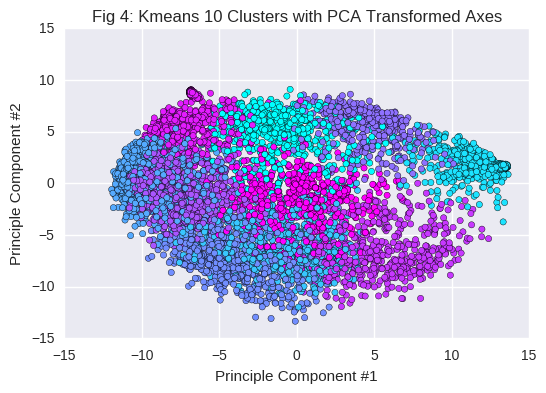

In [108]:
# Plot the clustered data points on the projected axes 
plt.figure()
plt.subplot(111)

plt.scatter(Xproj[:,0], Xproj[:,1], c=res_label, cmap=plt.cm.cool)
plt.title('Fig 4: Kmeans 10 Clusters with PCA Transformed Axes')
plt.xlabel('Principle Component #1')
plt.ylabel('Principle Component #2')

**Figure 4**: The plot shows the data points of riderships colored w.r.t kmeans clustering labels on the projected 2 dimensions (transformed by PCA) There are a total of 10 different clusters based on the similarity of their "station-card type" ridership characteristics.